# News Article Sentiment Classification

In this hands-on workshop, we'll practice classifying text on a slightly larger dataset.

Input: 8000 news articles that are labeled by relevance to the US Economy.

Task: Fit a model that classifies the articles based on whether each is relevant to the US Economy. This is a binary classification task.

Other uses of the same dataset (feel free to practice these on your owntime):
- Multi-class classification on positivity score
- Regression on relevance confidence, for the relevant articles

## Dataset

CSV: https://www.figure-eight.com/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

Source: https://www.figure-eight.com/data-for-everyone/

Description:

>Contributors read snippets of news articles. They then noted if the article was relevant to the US economy and, if so, what the tone of the article was. Tone was judged on a 9 point scale (from 1 to 9, with 1 representing the most negativity). Dataset contains these judgments as well as the dates, source titles, and text. Dates range from 1951 to 2014.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration (20 minutes)

1. Load the data into pandas
2. Check for NaNs (if any) and decide what you would do with them

In [2]:
df = pd.read_csv('C:/Users/thang/Documents/Thangamani/NUS/courseware/mldds-courseware/03_TextImage/Full-Economic-News-DFE-839861.csv', encoding='latin1',
                usecols=['relevance', 'text'])
df.head()

,relevance,text
0,yes,NEW YORK -- Yields on most certificates of dep...
1,no,The Wall Street Journal Online</br></br>The Mo...
2,no,WASHINGTON -- In an effort to achieve banking ...
3,no,The statistics on the enormous costs of employ...
4,yes,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
df.drop(df.loc[df.relevance=='not sure'].index, inplace=True)
df.relevance.unique()

array(['yes', 'no'], dtype=object)

## Data Transformation (60 minutes)

1. Convert the relevance "yes/no" into numbers using LabelEncoder
2. Perform text feature extraction on the "text" column:

   a. Use spaCy to tokenize and lemmatize.
   
   b. Pass the tokenized text into TfidfVectorizer. You can decide to train with 1-gram or 2-gram (or more if your computer is faster)

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['y'] = encoder.fit_transform(df.relevance)
df.head()

,relevance,text,y
0,yes,NEW YORK -- Yields on most certificates of dep...,1
1,no,The Wall Street Journal Online</br></br>The Mo...,0
2,no,WASHINGTON -- In an effort to achieve banking ...,0
3,no,The statistics on the enormous costs of employ...,0
4,yes,NEW YORK -- Indecision marked the dollar's ton...,1


In [5]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en_core_web_sm')
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

# transformation function to use in pd.DataFrame.apply()
def tokenize_text(text):
    """Tokenizes the text by lemmatizing and removing stop words
    Args:
        text - the input text
    Returns:
        a list of tokens
    """
    # process the text
    doc = nlp(text)
    
    # https://spacy.io/api/token
    lemmas = [lemmatizer(token.text, token.pos_) for token in doc
              if not token.is_stop and token.is_alpha]

    # create a string
    return ' '.join([item for sublist in lemmas for item in sublist])

In [6]:
# Test
%time tokenize_text(df.text[0])

Wall time: 80.8 ms


'new york yield certificate deposit offer major bank drop tenth percentage point late week reflect overall decline short term interest on small denomination consumer cd sell directly bank average yield month deposit fall week end yesterday accord survey banxquote money markets wilmington information on month consumer deposit average yield sink week accord banxquote two bank banxquote survey citibank new york corestates pennsylvania pay threemonth small denomination decline somewhat small year consumer cd ease banxquote yield month month treasury bill sell monday auction plummet fifth percentage point previous week respectively'

In [7]:
# Tokenize the column (takes about 10 minutes)
%time df_tokenized = df.text.apply(tokenize_text)

# Save the tokenized columns to CSV, so that we don't have to tokenize again
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html

df['tokenized'] = df_tokenized

df.to_csv('C:/Users/thang/Documents/Thangamani/NUS/courseware/mldds-courseware/03_TextImage/Full-Economic-News-DFE-839861.tokenized.csv', encoding='latin1',
          index=False)

Wall time: 8min 57s


In [8]:
df = pd.read_csv('C:/Users/thang/Documents/Thangamani/NUS/courseware/mldds-courseware/03_TextImage/Full-Economic-News-DFE-839861.tokenized.csv', encoding='latin1')
df.head()

,relevance,text,y,tokenized
0,yes,NEW YORK -- Yields on most certificates of dep...,1,new york yield certificate deposit offer major...
1,no,The Wall Street Journal Online</br></br>The Mo...,0,the wall street journal the morning brief look...
2,no,WASHINGTON -- In an effort to achieve banking ...,0,washington in effort achieve banking reform se...
3,no,The statistics on the enormous costs of employ...,0,the statistic enormous cost employee drug abus...
4,yes,NEW YORK -- Indecision marked the dollar's ton...,1,new york indecision mark dollar tone trader pa...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply the vectorizer on all tokenized rows
vectorizer = TfidfVectorizer(lowercase=False, decode_error='ignore')

X = vectorizer.fit_transform(df.tokenized)

# print a few features
print(vectorizer.get_feature_names()[:10])

['aa', 'aaa', 'aacer', 'aadvantage', 'aagrf', 'aairl', 'aalrl', 'aame', 'aap', 'aaron']


In [10]:
# check the distribution of the relevant / irrelevant articles
df.groupby(['y']).size()

y
0    6571
1    1420
dtype: int64

In [11]:
X.todense?

## Visualize (20 minutes)

Use `TSNE` to visualize the Tfidf vectors into a 2-D plot or 1-D plot

Wall time: 22min 51s
(3996, 2)


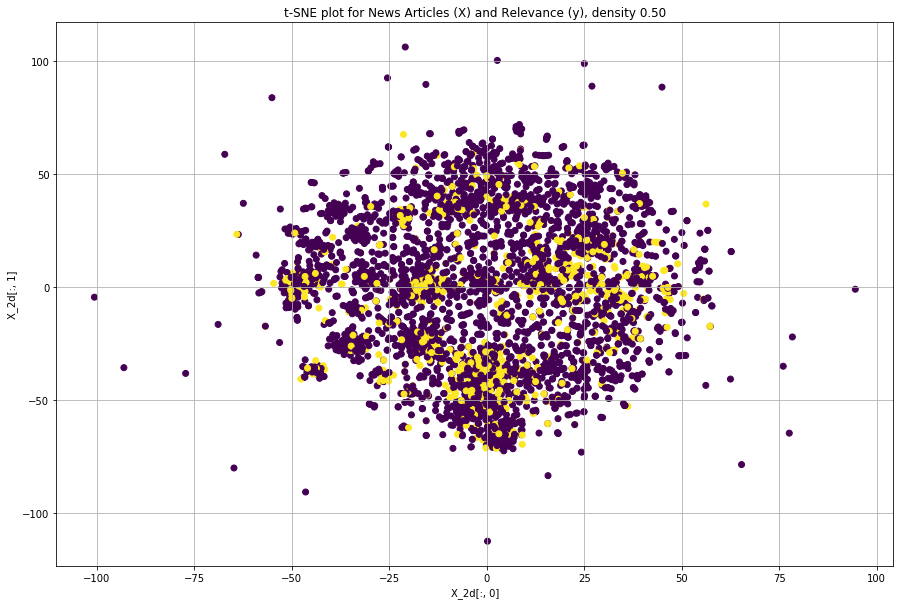

In [12]:
from sklearn.manifold import TSNE

# Sample a portion of the dataset for t-SNE (otherwise too slow)
density = 0.5

df_display = pd.DataFrame(X.todense())
df_display['y'] = df.y

# random sample
sample = df_display.sample(frac=density, random_state=42)

# only take the X for t-SNE
sample_X = sample.iloc[:, :-1] # pick all but the last column ('y')

tsne = TSNE(n_components=2, random_state=42)

%time X_2d = tsne.fit_transform(sample_X)

print(X_2d.shape)

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=sample.y)

ax.set(title='t-SNE plot for News Articles (X) and Relevance (y), density %.2f' % density,
       xlabel='X_2d[:, 0]', ylabel='X_2d[:, 1]')
ax.grid()
plt.show()

Wall time: 5min 34s
(2397, 1)


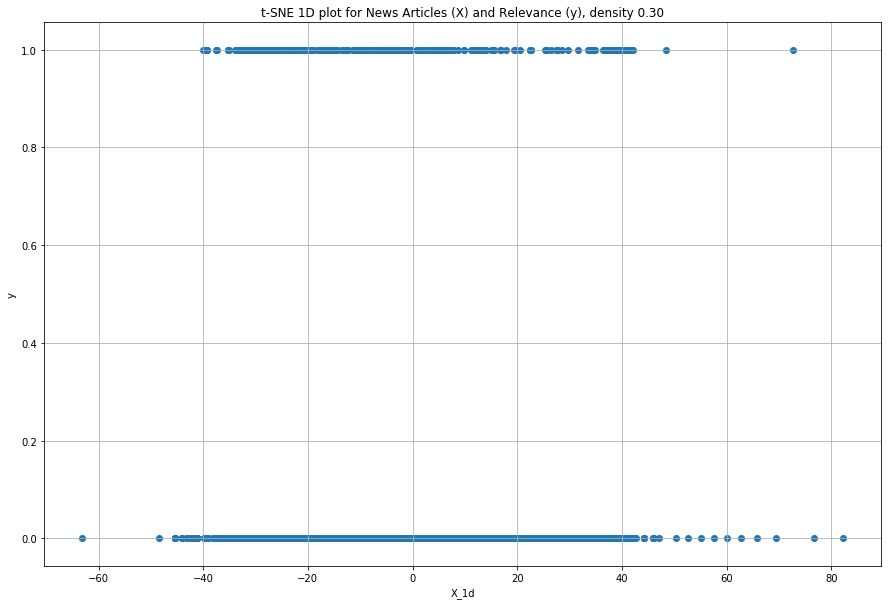

In [7]:
tsne = TSNE(n_components=1, random_state=42)
%time X_1d = tsne.fit_transform(sample_X)

print(X_1d.shape)

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_1d, sample.y)

ax.set(title='t-SNE 1D plot for News Articles (X) and Relevance (y), density %.2f' % density,
       xlabel='X_1d', ylabel='y')
ax.grid()
plt.show()

## Train (30 minutes)

1. Train/test split and shuffle the dataset
2. Train your favourite models with the dataset.  Keep in mind that KNeighbors, SVM and MLPClassifier can be slow.
3. Get classification_report metric

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df.y, random_state=42)

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Can't deal with sparse matrices (memory intensive):
# - Naive Bayes

from sklearn.metrics import classification_report

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(tol=1e-3, max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    #MLPClassifier(random_state=42), # slow and not so good...
    KNeighborsClassifier()    
]

for clf in classifiers:
    print(type(clf))
    %time clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))

<class 'sklearn.dummy.DummyClassifier'>
Wall time: 1 ms
             precision    recall  f1-score   support

          0       0.81      0.83      0.82      1621
          1       0.18      0.17      0.18       377

avg / total       0.69      0.70      0.70      1998

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Wall time: 214 ms
             precision    recall  f1-score   support

          0       0.82      0.99      0.90      1621
          1       0.54      0.07      0.13       377

avg / total       0.77      0.81      0.75      1998

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
Wall time: 60.7 ms
             precision    recall  f1-score   support

          0       0.83      0.96      0.89      1621
          1       0.44      0.15      0.22       377

avg / total       0.76      0.80      0.76      1998

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Wall time: 8.1 s
             precision    recall  f1-score   support

          0     

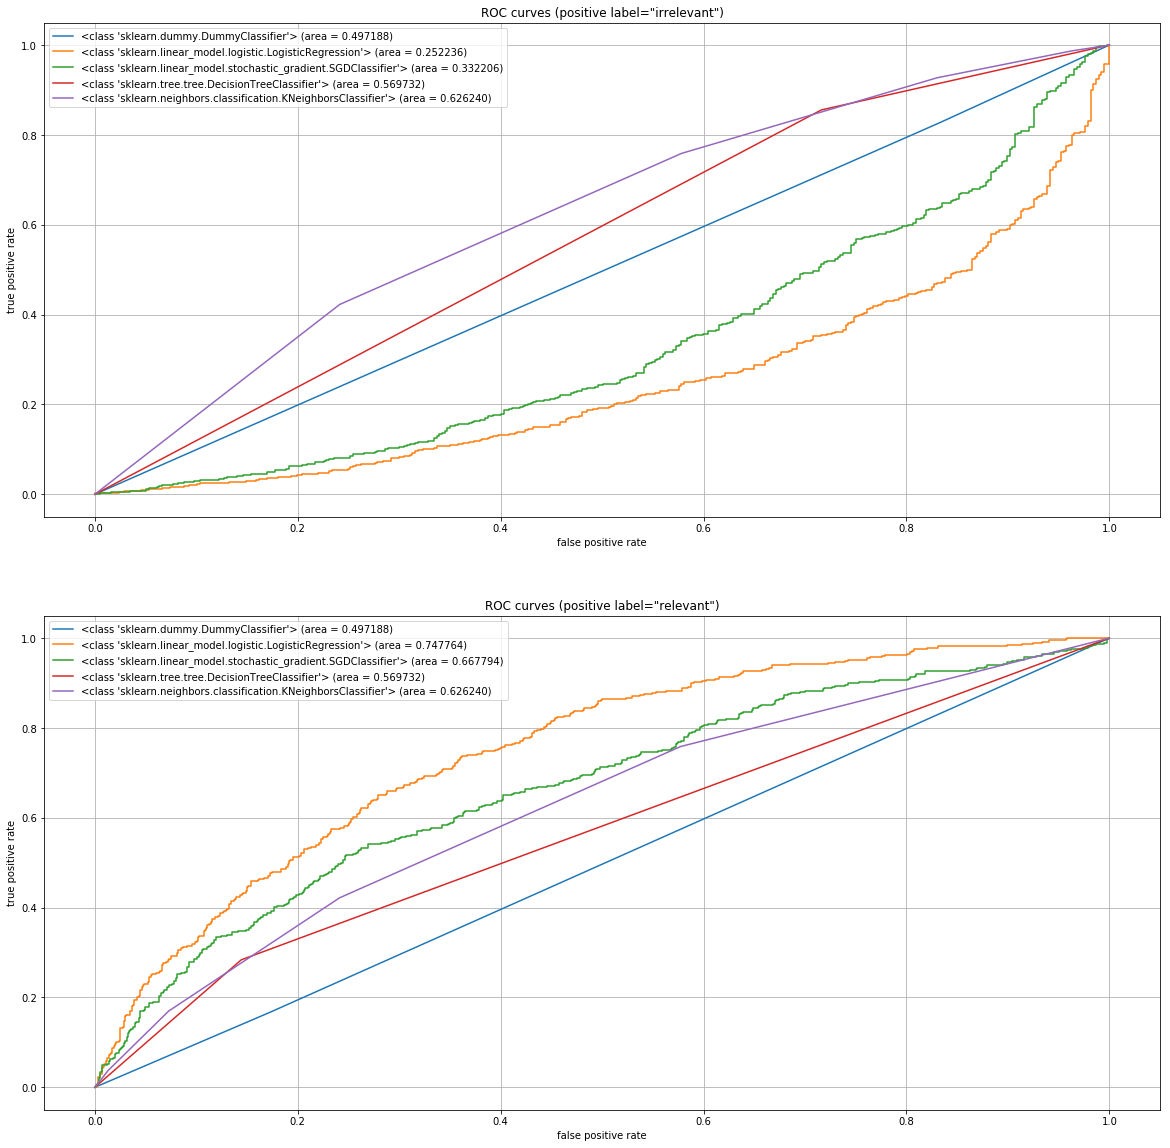

In [8]:
# Example of plotting the ROC curves to compare classifiers
from sklearn.metrics import roc_curve, auc

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

#
# plot the classifiers
#
for clf in classifiers:
    # some classifiers provide .decision_function(), others provide .predict_proba()
    if hasattr(clf, 'decision_function'):
        y_confidence = clf.decision_function(X_test)
    
        # positive label = class 0
        fpr0, tpr0, _ = roc_curve(y_test, y_confidence, pos_label=0)

        # positive label = class 1
        fpr1, tpr1, _ = roc_curve(y_test, y_confidence, pos_label=1)    
    else:
        y_confidence = clf.predict_proba(X_test)

        # positive label = class 0
        fpr0, tpr0, _ = roc_curve(y_test, y_confidence[:, 0], pos_label=0)

        # positive label = class 1
        fpr1, tpr1, _ = roc_curve(y_test, y_confidence[:, 1], pos_label=1)    

    ax1.plot(fpr1, tpr1, label='%s (area = %f)' % (clf.__class__, auc(fpr1, tpr1)))
    ax0.plot(fpr0, tpr0, label='%s (area = %f)' % (clf.__class__, auc(fpr0, tpr0)))        


# put the plots together
ax0.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="irrelevant")')
ax0.legend()
ax0.grid()

ax1.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="relevant")')
ax1.legend()
ax1.grid()

plt.show()

## Predictions (30 minutes)

1. Go to reuters.com or anywhere and find any news article.
2. Get the text of the article and pass it to your best performing model.

  a. You need to first tokenize and lemmatize your test text
  
  b. Apply `TfidfVectorizer` to get the test input vector
  
  c. Run `predict` to see if your model correctly classified the text as relevant to the US Economy

In [9]:
sample_news = ["""A sell-off in Chinese markets knocked Asian stocks on Wednesday as U.S. threats of tariffs on an additional $200 billion worth of Chinese goods pushed the world’s two biggest economies ever closer to a full-scale trade war.
FILE PHOTO: People walk past an electronic board showing Japan's Nikkei average outside a brokerage in Tokyo, Japan, March 23, 2018. REUTERS/Toru Hanai
Washington proposed the extra tariffs after efforts to negotiate a solution to the dispute failed to reach an agreement, senior administration officials said on Tuesday.

The United States had just imposed tariffs on $34 billion worth of Chinese goods on Friday, drawing immediate retaliatory duties from Beijing on U.S. imports in the first shots of a heated trade war. U.S. President Donald Trump had warned then that his country may ultimately impose tariffs on more than $500 billion worth of Chinese imports - roughly the total amount of U.S. imports from China last year.

“With no early end appearing to be in sight for the escalating ‘tit-for-tat’ world trade frictions and rising trade protectionism, global trade wars have become one of the key downside risks to world growth and trade in the second half of 2018 and for 2019,” wrote Rajiv Biswas, Asia Pacific chief economist at IHS Markit.

MSCI’s broadest index of Asia-Pacific shares outside Japan fell 1.1 percent. The index had gained for the past two sessions, having enjoyed a lull from the trade war fears that lashed global markets last week."""
,
"""TOKYO (Reuters) - Japanese regulators on Wednesday said Apple Inc (AAPL.O) may have breached antitrust rules by forcing mobile service providers to sell its iPhones cheaply and charge higher monthly fees, denying consumers a fair choice.

FILE PHOTO: A member of Apple staff takes pictures as new iPhone X begins to sell at an Apple Store in Beijing, China November 3, 2017. REUTERS/Damir Sagolj/File Photo
The Fair Trade Commission (FTC) said that Apple had forced NTT Docomo Inc (9437.T) , KDDI Corp (9433.T) and SoftBank Group Corp (9984.T) to offer subsidies and sell iPhones at a discount.

Apple Inc
190.35
AAPL.ONASDAQ
-0.00(-0.00%)
AAPL.O
AAPL.O9437.T9433.T9984.T
The FTC, which began looking into Apple’s sales practices in 2016, did not punish Apple as the U.S. company had agreed to revise its contracts with the carriers, it said
TOKYO (Reuters) - Japanese regulators on Wednesday said Apple Inc (AAPL.O) may have breached antitrust rules by forcing mobile service providers to sell its iPhones cheaply and charge higher monthly fees, denying consumers a fair choice.

FILE PHOTO: A member of Apple staff takes pictures as new iPhone X begins to sell at an Apple Store in Beijing, China November 3, 2017. REUTERS/Damir Sagolj/File Photo
The Fair Trade Commission (FTC) said that Apple had forced NTT Docomo Inc (9437.T) , KDDI Corp (9433.T) and SoftBank Group Corp (9984.T) to offer subsidies and sell iPhones at a discount.

Apple Inc
190.35
AAPL.ONASDAQ
-0.00(-0.00%)
AAPL.O
AAPL.O9437.T9433.T9984.T
The FTC, which began looking into Apple’s sales practices in 2016, did not punish Apple as the U.S. company had agreed to revise its contracts with the carriers, it said
"""
,
"""Stocks fell, the dollar gained and commodities slid with emerging-market assets after the U.S. fired a new shot in its brewing trade war with China.

S&P 500 futures slumped with the Stoxx Europe 600 Index and MSCI Asia Pacific Index following the Trump administration’s release of the biggest list yet of Chinese goods it may hit with tariff increases. The Asian nation vowed to retaliate, and shares in Shanghai led the retreat as the yuan weakened.

The potential escalation spurred advances in the dollar and Treasuries, while emerging-market stocks and currencies both declined. Metals bore the brunt of the reaction in commodities, with copper, nickel and zinc all sliding.
"""
]

df_sample_news = pd.DataFrame(data={'text': sample_news})

# first tokenize and lemmatize your test text
df_sample_news['tokenized_text'] = df_sample_news.text.apply(tokenize_text)
df_sample_news

,text,tokenized_text
0,A sell-off in Chinese markets knocked Asian st...,a sell chinese market knock asian stock wednes...
1,TOKYO (Reuters) - Japanese regulators on Wedne...,tokyo reuters japanese regulator wednesday say...
2,"Stocks fell, the dollar gained and commodities...",stock fall dollar gain commodity slide emerge ...


In [10]:
# Apply TfidfVectorizer to get the test input vector
sample_news = vectorizer.transform(df_sample_news.tokenized_text).todense()
print(sample_news.shape)

(3, 31876)


In [11]:
# Run predict to see if your model correctly classified the text as relevant to the US Economy

for clf in classifiers:
    print(clf.__class__)
    predictions = clf.predict(sample_news)
    
    if hasattr(clf, 'predict_proba'):
        probabilities = clf.predict_proba(sample_news)
        for prediction, probability in (zip(predictions, probabilities)):
            print(prediction, probability)
    else:
        distances = clf.decision_function(sample_news)
        for prediction, distance in (zip(predictions, distances)):
            print(prediction, distance)

<class 'sklearn.dummy.DummyClassifier'>
0 [1 0]
1 [0 1]
0 [1 0]
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0 [0.92866315 0.07133685]
0 [0.94136573 0.05863427]
0 [0.90656126 0.09343874]
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0 -1.7166693516991895
0 -1.4271235296624216
0 -1.7191110187803522
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
0 [1. 0.]
0 [1. 0.]
0 [1. 0.]
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
0 [0.8 0.2]
0 [0.8 0.2]
0 [1. 0.]


## Exploring Improvements 1 - Manually Balance Training Set

Some classifiers accept the `class_weight='balanced'` option for unbalanced training sets. This should improve the classification metric somewhat.

In practice, manually balancing can provide better results because:
- you get finer-grained control on the proportion, and
- allows you to use classifiers that don't support `class_weight='balanced'` (such as MLPClassifier)

In [12]:
# check the distribution of the relevant / irrelevant articles
df.groupby(['y']).size()

y
0    6571
1    1420
dtype: int64

In [13]:
# let's cut the irrelevant articles by 1/4
# Alternatively, you can also collect and label more relevant articles
df_irrelevant = df[df.y == 0].sample(frac=0.25, random_state=42)
df_irrelevant.shape

(1643, 4)

In [14]:
# keep all the relevant articles
df_relevant = df[df.y == 1]
df_relevant.shape

(1420, 4)

In [15]:
# make our balanced dataset
df_balanced = pd.concat([df_irrelevant, df_relevant], axis=0) # concat rows
df_balanced.groupby(['y']).size()

y
0    1643
1    1420
dtype: int64

In [16]:
df_balanced.columns

Index(['relevance', 'text', 'y', 'tokenized'], dtype='object')

In [17]:
# Featurize, fit, metrics, predict, ...

# featurize
vectorizer_balanced = TfidfVectorizer(lowercase=False, decode_error='ignore')
X = vectorizer_balanced.fit_transform(df_balanced.tokenized)

# fit
X_train, X_test, y_train, y_test = train_test_split(X, df_balanced.y, random_state=42)
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# metrics
print(classification_report(y_test, clf.predict(X_test)))

# predict
sample_news = vectorizer_balanced.transform(df_sample_news.tokenized_text).todense()
predictions = clf.predict(sample_news)

if hasattr(clf, 'predict_proba'):
    print('Prediction [P(y=0|X) P(y=1|X)]')
    probabilities = clf.predict_proba(sample_news)
    for prediction, probability in (zip(predictions, probabilities)):
        print(prediction, probability)
else:
    print('Prediction [Distance(y=0|X) Distance(y=1|X)]')
    distances = clf.decision_function(sample_news)
    for prediction, distance in (zip(predictions, distances)):
        print(prediction, distance)

             precision    recall  f1-score   support

          0       0.71      0.76      0.73       423
          1       0.67      0.62      0.65       343

avg / total       0.69      0.70      0.69       766

Prediction [P(y=0|X) P(y=1|X)]
0 [0.70579027 0.29420973]
0 [0.77243183 0.22756817]
0 [0.59805743 0.40194257]


## Exploring Improvements 2 - N-grams

N-grams can take up a lot of memory, especially if you try to convert .to_dense()

The workaround is to stick to scipy sparse matrices where possible. However, this will rule out certain classifiers such as Naive Bayes that only work for dense matrices.

Also, you can't use t-SNE with a sparse matrix.

In [18]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(1, 2))

# Featurize, fit, metrics, predict, ...

# featurize

X = vectorizer_ngram.fit_transform(df_balanced.tokenized)

# fit
X_train, X_test, y_train, y_test = train_test_split(X, df_balanced.y, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)

# metrics
print(classification_report(y_test, clf.predict(X_test)))

# predict
sample_news = vectorizer_ngram.transform(df_sample_news.tokenized_text).todense()
predictions = clf.predict(sample_news)
if hasattr(clf, 'predict_proba'):
    print('Prediction [P(y=0|X) P(y=1|X)]')
    probabilities = clf.predict_proba(sample_news)
    for prediction, probability in (zip(predictions, probabilities)):
        print(prediction, probability)
else:
    print('Prediction [Score (negative: class 0, positive: class 1)]')
    scores = clf.decision_function(sample_news)
    for prediction, score in (zip(predictions, scores)):
        print(prediction, score)

             precision    recall  f1-score   support

          0       0.70      0.78      0.74       423
          1       0.69      0.60      0.64       343

avg / total       0.70      0.70      0.69       766

Prediction [P(y=0|X) P(y=1|X)]
0 [0.62927179 0.37072821]
0 [0.70793182 0.29206818]
0 [0.5618609 0.4381391]


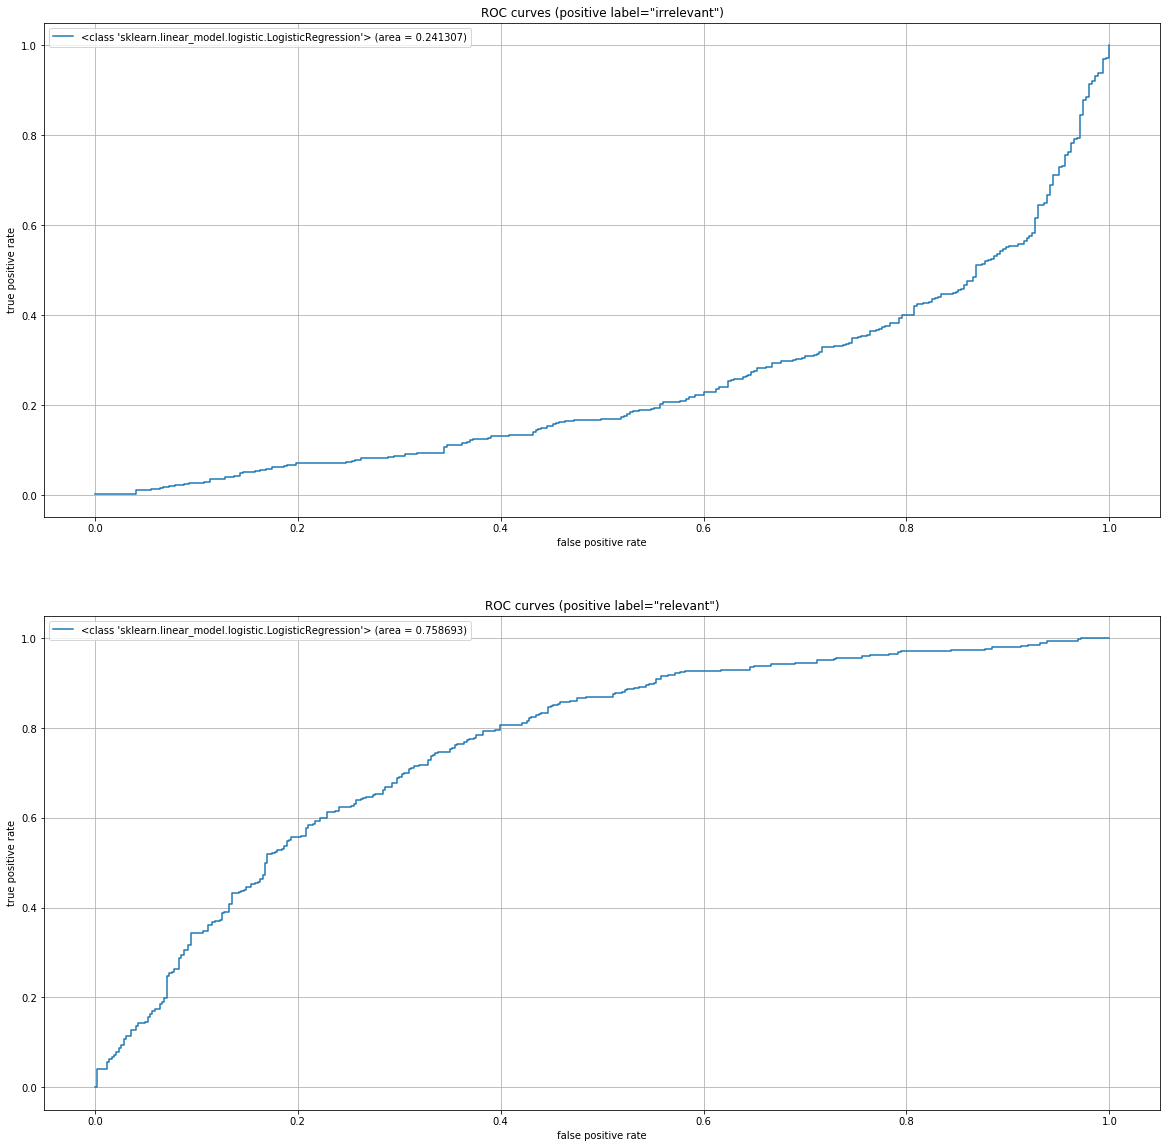

In [19]:
# Replot ROC curve
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# some classifiers provide .decision_function(), others provide .predict_proba()
if hasattr(clf, 'decision_function'):
    y_confidence = clf.decision_function(X_test)

    # positive label = class 0
    fpr0, tpr0, _ = roc_curve(y_test, y_confidence, pos_label=0)

    # positive label = class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_confidence, pos_label=1)    
else:
    y_confidence = clf.predict_proba(X_test)

    # positive label = class 0
    fpr0, tpr0, _ = roc_curve(y_test, y_confidence[:, 0], pos_label=0)

    # positive label = class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_confidence[:, 1], pos_label=1)    

ax1.plot(fpr1, tpr1, label='%s (area = %f)' % (clf.__class__, auc(fpr1, tpr1)))
ax0.plot(fpr0, tpr0, label='%s (area = %f)' % (clf.__class__, auc(fpr0, tpr0)))        

# put the plots together
ax0.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="irrelevant")')
ax0.legend()
ax0.grid()

ax1.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves (positive label="relevant")')
ax1.legend()
ax1.grid()

plt.show()

## Prediction Probabilities vs. Decision Functions

Let's explore how to interpret the prediction probability and decision function values.

Most classifiers provide one or the other.

### Prediction Probability

Prediction probability returns P(y=class|X).

The output below is for `LogisticRegression.predict_proba(sample_news)`, where `sample_news` is the test input (like X_test):

```
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0 [0.92866315 0.07133685]
0 [0.94136573 0.05863427]
0 [0.90656126 0.09343874]
```

There are 3 entries, one for each test news article. We have a total of 3 news articles that we fed to the classifier after fitting.

`0 [0.92866315 0.07133685]` means:

- Prediction = 0
- P(y=0|X) = 0.928
- P(y=1|X) = 0.071

The LogisticRegression classifier is 92.8% confident that this news article is irrelevant to the US Economy.

>A sell-off in Chinese markets knocked Asian stocks on Wednesday as U.S. threats of tariffs on an additional $200 billion >worth of Chinese goods pushed the world’s two biggest economies ever closer to a full-scale trade war...

Well, that's not very good. A human reader can tell that the news IS relevant. 

After balancing the dataset so that the proportion of the relevant vs. irrelevant news is closer to 1:1 AND adding bigrams, we have:

```
Prediction [P(y=0|X) P(y=1|X)]
0 [0.62927179 0.37072821]
0 [0.70793182 0.29206818]
0 [0.5618609 0.4381391]
```

The LogisticRegression classifier is now only 62.9% confident that the same news article is irrelevant to the US Economy. It's 37.0% confident that the article is relevant. This is a vast improvement in machine learning terms, even though the classifier is still not correct.

There are other improvements that can be explored, for example by limiting the vocabulary to specific "economy-related" terms when setting up TfidfVectorizer:

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

>vocabulary : Mapping or iterable, optional
>
>Either a Mapping (e.g., a dict) where keys are terms and values are indices in the feature matrix, or an iterable over >terms. If not given, a vocabulary is determined from the input documents.

### Decision Function (SGD Classifier)

Decision functions usually return the signed distance from the classification boundary / hyperplane. 

The hyperplane is simply an N-dimensional surface (where N is the number of features) that separates the different classes. 

For our binary classification task, training a classifier is akin to finding the "best" boundary that splits the 0-class samples from the 1-class samples. 

The decision_function determines two things:
1. whether the test sample lies inside or outside the boundary (where inside means it is part of the class, outside means it's not part of the class)
2. distance of that sample from the boundary.

The output below is for `SGDClassifier.decision_function(sample_news)`, where `sample_news` is the test input (like X_test):

```
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0 -1.7166693516991895
0 -1.4271235296624216
0 -1.7191110187803522
```

There are 3 entries, one for each test news article. We have a total of 3 news articles that we fed to the classifier after fitting.

`0 -1.7166693516991895` means:

- Prediction = 0
- Score: -1.72 (the more negative, the more confident the classifier is of class 0). 

The [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function) says:

```
  array, shape=(n_samples,) if n_classes == 2 else (n_samples, n_classes)
            Confidence scores per (sample, class) combination. In the binary
            case, confidence score for self.classes_[1] where >0 means this
            class would be predicted.
```

The return value is different for binary vs. multi-class classification tasks:
- Binary classification, `decision_function` returns:
   - For each sample
      - if confidence score > 0, predict class 1, else predict class 0
- Multi-class classification, `decision_function` returns:
   - For each sample
      - confidence score 1 of class 1
      - confidence score 2 of class 2
      - confidence score 3 of class 3
      - ...

In our task, we are performing binary classification, so the vector `[0, -1.7166693516991895]` results in a prediction of 0, because -1.7166693516991895 is negative.

A quick look at the [source code](https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/linear_model/base.py#L307) for `SGDClassifier` shows that the scores are computed as the dot product of X and W.T (W-transpose), plus the intercept.

```
        scores = safe_sparse_dot(X, self.coef_.T,
                                 dense_output=True) + self.intercept_
```

Note that the above decision_function implementation is specific to the classifier. Other classifiers may have different ways of 'scoring'.

In [22]:
# print out what the "positive score" class is for our SGD classifier
print(classifiers[2])

print(classifiers[2].classes_[1])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
1


After balancing the dataset so that the proportion of the relevant vs. irrelevant news is closer to 1:1 AND adding bigrams, we have:

```
Prediction [Score (negative: class 0, positive: class 1)]
0 -0.5025550605897062
0 -0.7690046648925115
0 -0.3407931632076132
```

`0 -0.5025550605897062` means that the classifier still thinks the first article is class 0, but it is less "confident" than before when the score was (-1.72).

In [20]:
from sklearn.base import clone

# clone the "baseline" SGDClassifier so that we can train one with N-grams
# with the same classifier hyper-parameters.
#
# clone does not copy the weights
sgd_ngram = clone(classifiers[2])

sgd_ngram.fit(X_train, y_train)

# metrics
print(classification_report(y_test, sgd_ngram.predict(X_test)))

# predict
sample_news = vectorizer_ngram.transform(df_sample_news.tokenized_text).todense()
predictions = clf.predict(sample_news)

print('Prediction [Score (negative: class 0, positive: class 1)]')
scores = sgd_ngram.decision_function(sample_news)
for prediction, score in (zip(predictions, scores)):
    print(prediction, score)

             precision    recall  f1-score   support

          0       0.70      0.75      0.73       423
          1       0.66      0.61      0.64       343

avg / total       0.69      0.69      0.69       766

Prediction [Score (negative: class 0, positive: class 1)]
0 -0.5025550605897062
0 -0.7690046648925115
0 -0.3407931632076132


## ROC curve

This section describes how to make sense out of the ROC curve.

The ROC curve plots the true positive rate against the false positive rate, at increasing scores.

- When the dataset is 
- Before the dataset was balanced, the classifier is predicting much more false positives than true positives. 


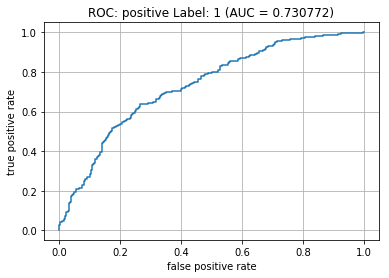

In [21]:
fig, ax = plt.subplots()

y_confidence = sgd_ngram.decision_function(X_test)

# How to debug python scripts in Jupyter Notebook
#
# 1. Uncomment this in code (which enables the debugger)
# import pdb; pdb.set_trace()
#
# 2. Type these in the debugger
# import sklearn.metrics
# break sklearn.metrics.roc_curve
# break sklearn.metrics.ranking._binary_clf_curve
# c
#
# 3. debug, use https://docs.python.org/3.6/library/pdb.html#module-pdb as a reference
#
# 4. Quit the debugger
# q
# 

# positive label = class 1
pos_label=1

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_confidence, pos_label=pos_label)    

ax.plot(fpr1, tpr1)
ax.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC: positive Label: 1 (AUC = %f)' % auc(fpr1, tpr1))
ax.grid()
plt.show()

In [25]:
print('Positive label: 1')
print('------ First 10 --------')
print('False positive rate\n', fpr1[:10],
      '\nTrue positive rate\n', tpr1[:10],
      '\nScore\n', thresholds1[:10])

print('------ Last 10 --------')
print('False positive rate\n', fpr1[-10:],
      '\nTrue positive rate\n', tpr1[-10:],
      '\nScore\n', thresholds1[-10:])

Positive label: 1
------ First 10 --------
False positive rate
 [0.         0.         0.00236407 0.00236407 0.00945626 0.00945626
 0.0141844  0.0141844  0.01891253 0.01891253] 
True positive rate
 [0.00291545 0.02915452 0.02915452 0.04081633 0.04081633 0.04956268
 0.04956268 0.05830904 0.05830904 0.0728863 ] 
Score
 [1.46874178 1.26694108 1.21594639 1.16815034 1.15100328 1.10562152
 1.05099355 1.03940645 1.03466022 0.99944656]
------ Last 10 --------
False positive rate
 [0.86524823 0.91016548 0.91016548 0.91725768 0.91725768 0.92671395
 0.92671395 0.99763593 0.99763593 1.        ] 
True positive rate
 [0.98542274 0.98542274 0.98833819 0.98833819 0.99125364 0.99125364
 0.9941691  0.9941691  1.         1.        ] 
Score
 [-0.84935643 -0.91382551 -0.91626828 -0.93036143 -0.93240613 -0.96910107
 -0.98394672 -1.32415369 -1.34963084 -1.44212852]


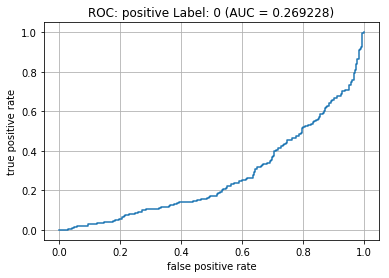

In [22]:
pos_label=0

fig, ax = plt.subplots()
fpr0, tpr0, thresholds0 = roc_curve(y_test, y_confidence, pos_label=pos_label)

ax.plot(fpr0, tpr0)
ax.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC: positive Label: %d (AUC = %f)' % (pos_label, auc(fpr0, tpr0)))
ax.grid()
plt.show()

In [27]:
print('Positive label: 0')
print('------ First 10 --------')
print('False positive rate\n', fpr0[:10],
      '\nTrue positive rate\n', tpr0[:10],
      '\nScore\n', thresholds0[:10])

print('------ Last 10 --------')
print('False positive rate\n', fpr0[-10:],
      '\nTrue positive rate\n', tpr0[-10:],
      '\nScore\n', thresholds0[-10:])

Positive label: 0
------ First 10 --------
False positive rate
 [0.         0.00291545 0.02915452 0.02915452 0.04081633 0.04081633
 0.04956268 0.04956268 0.05830904 0.05830904] 
True positive rate
 [0.         0.         0.         0.00236407 0.00236407 0.00945626
 0.00945626 0.0141844  0.0141844  0.01891253] 
Score
 [2.46874178 1.46874178 1.26694108 1.21594639 1.16815034 1.15100328
 1.10562152 1.05099355 1.03940645 1.03466022]
------ Last 10 --------
False positive rate
 [0.98542274 0.98542274 0.98833819 0.98833819 0.99125364 0.99125364
 0.9941691  0.9941691  1.         1.        ] 
True positive rate
 [0.86524823 0.91016548 0.91016548 0.91725768 0.91725768 0.92671395
 0.92671395 0.99763593 0.99763593 1.        ] 
Score
 [-0.84935643 -0.91382551 -0.91626828 -0.93036143 -0.93240613 -0.96910107
 -0.98394672 -1.32415369 -1.34963084 -1.44212852]


In [23]:
y_pred = sgd_ngram.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.70      0.75      0.73       423
          1       0.66      0.61      0.64       343

avg / total       0.69      0.69      0.69       766



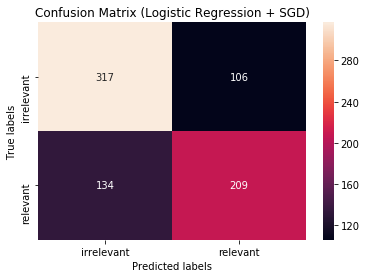

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix (Logistic Regression + SGD)') 
ax.xaxis.set_ticklabels(['irrelevant', 'relevant'])
ax.yaxis.set_ticklabels(['irrelevant', 'relevant'])
plt.show()

In [25]:
# Positive label = 0 (irrelevant)
# tpr = recall = tp / (tp + fn)
tpr_class_0 = 317 / (317 + 106)

# fpr = fn / (tp + fn) = 1 - tpr
fpr_class_0 = 106 / (317 + 106)

print('Positive label: 0', 'tpr', tpr_class_0, 'fpr', fpr_class_0)

Positive label: 0 tpr 0.7494089834515366 fpr 0.25059101654846333


In [26]:
# Positive label = 1 (relevant)

# tpr = recall = tp / (tp + fn)
tpr_class_1 = 209 / (209 + 134)

# fpr = fn / (tp + fn) = 1 - tpr
fpr_class_1 = 134 / (209 + 134)

print('Positive label: 1', 'tpr', tpr_class_1, 'fpr', fpr_class_1)

Positive label: 1 tpr 0.60932944606414 fpr 0.39067055393586003


## SVM Tuning

SVM tries to finds a decision hyperplane in a linearly separable sample space.

The decision hyperplane is the widest possible between two extreme samples.

If the sample space is not linearly separable, we apply a Kernel Function to perform the transformation.

In [27]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

print(classification_report(y_test, pred))

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.55      1.00      0.71       423
          1       0.00      0.00      0.00       343

avg / total       0.30      0.55      0.39       766



In [29]:
# The C parameter tells the SVM optimization how much
# you want to avoid misclassifying each training example.
#
# For large values of C, the optimization will choose a
# smaller-margin hyperplane if that hyperplane
# does a better job of getting all the training points
# classified correctly. 
#
# Conversely, a very small value of C will cause the optimizer
# to look for a larger-margin separating hyperplane, even if
# that hyperplane misclassifies more points.
#
# For very tiny values of C, you should get misclassified examples,
# often even if your training data is linearly separable.
#
# https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel

Cs = [0.001, 0.01, 0.1, 1, 10]

# Scaling term for Radial Basis Function kernel:
#   exp(-gamma ||x - x'||^2)
#
# This projects the X into a linearly separable space
#
# http://scikit-learn.org/stable/modules/svm.html#svm-kernels
gammas = [0.001, 0.01, 0.1, 1]

svc_params = {'C': Cs, 'gamma' : gammas}
    
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid=svc_params, verbose=True)
%time grid_search.fit(X_train, y_train)

pred = grid_search.predict(X_test)

print(grid_search.best_params_)
print(classification_report(y_test, pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.3min finished


Wall time: 8min 24s
{'C': 10, 'gamma': 0.1}
             precision    recall  f1-score   support

          0       0.70      0.75      0.72       423
          1       0.66      0.60      0.63       343

avg / total       0.68      0.68      0.68       766



In [30]:
best_svm = grid_search.best_estimator_

best_svm

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
from sklearn.manifold import TSNE

# Plot the T-SNE projection of the test dataset
# show the predictions in color

tsne_plot = TSNE(n_components=2, random_state=42)

%time X_test_2d = tsne_plot.fit_transform(X_test.todense())
print(X_test_2d.shape)

Wall time: 5min 6s
(766, 2)


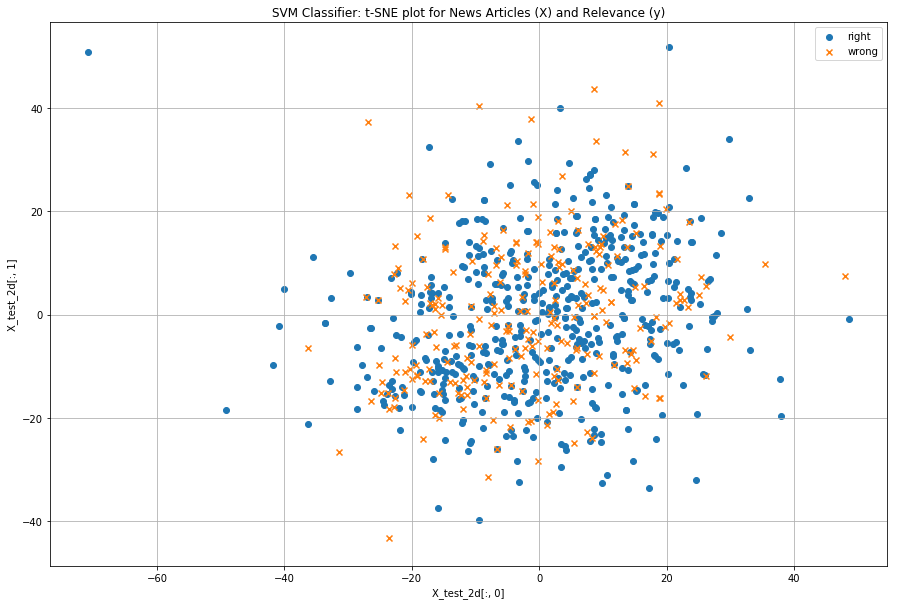

In [42]:
# Plot the T-SNE projection of the test dataset
# Mark the correct and wrong predictions

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_test_2d[y_test == pred, 0], X_test_2d[y_test == pred, 1],
           marker='o', label='right')
ax.scatter(X_test_2d[y_test != pred, 0], X_test_2d[y_test != pred, 1],
           marker='x', label='wrong')

ax.set(title='SVM Classifier: t-SNE plot for News Articles (X) and Relevance (y)',
       xlabel='X_test_2d[:, 0]', ylabel='X_test_2d[:, 1]')
ax.grid()
ax.legend()
plt.show()